## Setup & Installation

In [ ]:
# Install necessary libraries
!pip install --upgrade fiftyone wandb open-clip-torch nbformat
!pip install ftfy regex tqdm torchmetrics torch-fidelity
!pip install git+https://github.com/openai/CLIP.git

# Install UMAP for FiftyOne Brain visualization
!pip install umap-learn

# --- FIX: Re-install PyTorch with CUDA support ---
# 1. Uninstall current CPU version
!pip uninstall -y torch torchvision torchaudio

# 2. Install GPU version (CUDA 12.1)
# If this doesn't work, try cu118
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/openai/CLIP.git to c:\users\conscht\appdata\local\temp\pip-req-build-dgwreqpu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Conscht\AppData\Local\Temp\pip-req-build-dgwreqpu'

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (2449.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Part 1: Image Generation and Emebdding Extraction

In [2]:
# cd drive/MyDrive/Hands-on-CV3  # Commented out Google Colab specific path

In [3]:
import torch
import sys
import os

# Import our new utility module
import utils
from utils import ClassicLeNet5, CustomTorchImageDataset, train_epoch, val_epoch, evaluate_idk_performance

print(f"Torch version: {torch.__version__}")
print("Utils imported successfully.")

c:\Users\Conscht\anaconda3\envs\pointllm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.5.1+cu121
Utils imported successfully.


In [4]:
import clip

clip.available_models()
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

Sanity Check of the model

C:\Users\Conscht\AppData\Local\Temp\ipykernel_24796\2093297480.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_locati

Loaded weights from flowerDiff.pth
Generating 3 test images with Guidance Scale w=4.0...


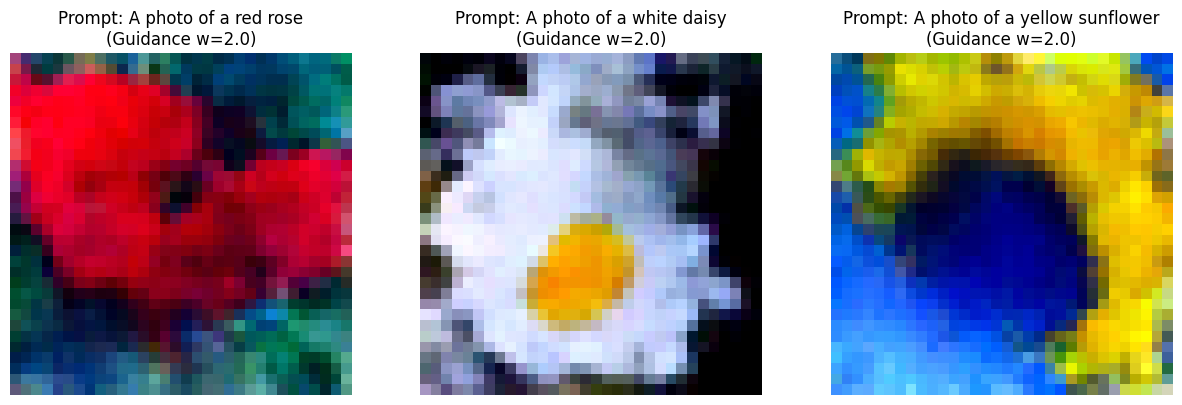

In [5]:
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import torch

N = 200     # Based on ressource limiations
BATCH_SIZE = 8
IMG_SIZE = 32
IMG_CH = 3
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)
B_start = 0.0001
B_end = 0.02
NUM_STEPS = 400

# Define paths
project_root = Path.cwd()
sys.path.append(str(Path(".").resolve()))

# Helper paths (Found in utilis/utils)
# Adding both parent layers in case of nested imports
sys.path.append(str(project_root / "utilis"))
sys.path.append(str(project_root / "utilis" / "utils"))

OUT_DIR = Path("generated_flowers")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. MODEL SETUP ---

try:
    # Try importing directly
    if 'UNet_utils' not in globals():
        import UNet_utils
    if 'ddpm_utils' not in globals():
        import ddpm_utils
        
    model = UNet_utils.UNet(
        T=400, img_ch=3, img_size=32, down_chs=(256, 256, 512),
        t_embed_dim=8, c_embed_dim=512
    ).to(device)

    # Ensure the path is correct relative to your environment
    weights_path = 'flowerDiff.pth' 
    
    if Path(weights_path).exists():
        model.load_state_dict(torch.load(weights_path, map_location=device))
        print(f"Loaded weights from {weights_path}")
    else:
        print(f"Warning: Weights file {weights_path} not found. Model is using random weights.")
        
    model.eval()

except ImportError as e:
    print(f"Error importing helper modules: {e}")
    print(f"Current sys.path: {sys.path}")
except NameError as e:
    print(f"NameError: {e}. Check if UNet_utils/ddpm_utils are defined.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# 1. Define Test Prompts
test_prompts = [
    "A photo of a red rose",
    "A photo of a white daisy",
    "A photo of a yellow sunflower"
]

print("Generating 3 test images with Guidance Scale w=4.0...")

# 2. Generate
if 'clip' in globals() and 'clip_model' in globals():
    try:
        text_tokens = clip.tokenize(test_prompts).to(device)
        c = clip_model.encode_text(text_tokens).float()

        B = torch.linspace(B_start, B_end, NUM_STEPS).to(device)
        ddpm = ddpm_utils.DDPM(B, device)

        def _to_01(x: torch.Tensor) -> torch.Tensor:
            if x.min() < 0:
                x = (x + 1) / 2.0
            return x.clamp(0, 1)


        # Sample
        x_test, _ = ddpm_utils.sample_w(
            model,
            ddpm,
            INPUT_SIZE,
            NUM_STEPS,
            c,
            device,
            w_tests=[1] #
        )
        # 3. Visualize Results
        plt.figure(figsize=(15, 5))
        for i in range(len(test_prompts)):
            # Convert from [C, H, W] to [H, W, C] for plotting
            img_tensor = _to_01(x_test[i]).cpu()
            img_np = img_tensor.permute(1, 2, 0).numpy()

            plt.subplot(1, 3, i+1)
            plt.imshow(img_np)
            plt.title(f"Prompt: {test_prompts[i]}\n(Guidance w=2.0)")
            plt.axis('off')

        plt.show()
    except Exception as e:
        print(f"Error during generation/visualization: {e}")
else:
    print("CLIP model not loaded. Please run the previous cell setup.")

In [6]:
# Install dependencies if missing
try:
    import einops
except ImportError:
    !pip install einops
    import einops

import sys
from pathlib import Path
import numpy as np
import torch
from torchvision.utils import save_image

# --- 1. CONFIGURATION
N = 200     # Based on ressource limiations
BATCH_SIZE = 8
IMG_SIZE = 32
IMG_CH = 3
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)
B_start = 0.0001
B_end = 0.02
NUM_STEPS = 400

# Define paths
project_root = Path.cwd()
sys.path.append(str(Path(".").resolve()))
# Add utils path
sys.path.append(str(project_root / "utilis" / "utils"))

# Import helper modules
try:
    import UNet_utils
    import ddpm_utils
except ImportError as e:
    raise ImportError(f"Error importing helper modules: {e}. 'utilis/utils' likely missing from path.") from e

OUT_DIR = Path("generated_flowers")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- DEVICE SELECTION ---
# Force GPU usage if available
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")


model = UNet_utils.UNet(
    T=400, img_ch=3, img_size=32, down_chs=(256, 256, 512),
    t_embed_dim=8, c_embed_dim=512
).to(device)

# Ensure the path is correct relative to your environment
weights_path = 'flowerDiff.pth' 
    
if Path(weights_path).exists():
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"Loaded weights from {weights_path}")
else:
    print(f"Warning: {weights_path} not found. Using random weights.")

model.eval()

# Check and move CLIP model if it exists globally
if 'clip_model' in globals():
    print("Moving CLIP model to selected device...")
    clip_model = clip_model.to(device)

# DDPM Setup
B = torch.linspace(B_start, B_end, NUM_STEPS).to(device)
ddpm = ddpm_utils.DDPM(B, device)

# --- 3. HOOKS FOR EMBEDDINGS ---
embeddings_storage = {}

def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook

# Register hook on down2
_ = model.down2.register_forward_hook(get_embedding_hook('down2'))

# --- 4. HELPER FUNCTIONS ---
def _to_01(x: torch.Tensor) -> torch.Tensor:
    if x.min() < 0:
        x = (x + 1) / 2.0
    return x.clamp(0, 1)

def cycle_prompts(prompts, n):
    """Cycles through the prompt list to match the requested number of images."""
    return (prompts * ((n + len(prompts) - 1) // len(prompts)))[:n]

@torch.no_grad()
def sample_flowers_with_embeddings(prompt_list, w=2):
    embeddings_storage.clear()

    # Ensure CLIP model is on the correct device
    if next(clip_model.parameters()).device != device:
        clip_model.to(device)

    text_tokens = clip.tokenize(prompt_list).to(device)
    c = clip_model.encode_text(text_tokens).float()

    x_gen, _ = ddpm_utils.sample_w(
        model,
        ddpm,
        INPUT_SIZE,
        NUM_STEPS,
        c,
        device,
        w_tests=[w]
    )

    down2 = embeddings_storage["down2"]          # [B, C, H, W]
    down2_vec = down2.mean(dim=(2, 3))           # [B, C] Global Average Pooling

    x_gen = x_gen[:len(prompt_list)]
    down2_vec = down2_vec[:len(prompt_list)]

    return x_gen, down2_vec

# --- 5. MAIN GENERATION LOOP ---
text_prompts = [
    "A photo of a red rose",
    "A photo of a white daisy",
    "A photo of a yellow sunflower"
]

text_prompts_seed = text_prompts
all_prompts = cycle_prompts(text_prompts_seed, N)

image_paths = []
prompt_per_image = []
unet_embs = []

print(f"Starting generation of {N} images...")

idx = 0
while idx < N:
    # Slice the prompts for this batch
    batch_prompts = all_prompts[idx : idx + BATCH_SIZE]

    # Generate
    x_gen, emb_vec = sample_flowers_with_embeddings(batch_prompts)

    # Process results
    x01 = _to_01(x_gen).cpu()
    emb_np = emb_vec.detach().cpu().numpy()

    for j in range(len(batch_prompts)):
        current_id = idx + j
        fp = OUT_DIR / f"gen_{current_id:06d}.png"

        save_image(x01[j], fp)

        image_paths.append(str(fp))
        prompt_per_image.append(batch_prompts[j])
        unet_embs.append(emb_np[j].astype(np.float32))

    idx += len(batch_prompts)
    print(f"Generated {idx}/{N}")

unet_embs_np = np.stack(unet_embs, axis=0)  # [N, C]
print("Done!")
print("Generated:", len(image_paths), "Embeddings:", unet_embs_np.shape)

C:\Users\Conscht\AppData\Local\Temp\ipykernel_24796\2114849695.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_locati

Loaded weights from flowerDiff.pth
Moving CLIP model to selected device...
Starting generation of 200 images...
Generated 8/200
Generated 16/200
Generated 24/200
Generated 32/200
Generated 40/200
Generated 48/200
Generated 56/200
Generated 64/200
Generated 72/200
Generated 80/200
Generated 88/200
Generated 96/200
Generated 104/200
Generated 112/200
Generated 120/200
Generated 128/200
Generated 136/200
Generated 144/200
Generated 152/200
Generated 160/200
Generated 168/200
Generated 176/200
Generated 184/200
Generated 192/200
Generated 200/200
Done!
Generated: 200 Embeddings: (200, 512)


## Part 2: Evaluation with CLIP Score and Frechet Inception Distance

First download the data for comparson

In [7]:
import tarfile
import urllib.request
from pathlib import Path
import shutil

# 1. Define URL and Paths
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
archive_path = Path("flower_photos.tgz")
data_dir = Path("flower_photos")  # This is where images will be extracted

# 2. Download
if not archive_path.exists():
    print(f"Downloading TF-Flowers from {dataset_url}...")
    urllib.request.urlretrieve(dataset_url, archive_path)
    print("Download complete.")

# 3. Extract
if not data_dir.exists():
    print("Extracting images...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall()
    print(f"Extracted to {data_dir.resolve()}")
else:
    print(f"Data already exists at {data_dir.resolve()}")

# 4. Quick verification
jpg_count = len(list(data_dir.glob("**/*.jpg")))
print(f"Found {jpg_count} images in dataset.")

Data already exists at C:\Users\Conscht\MNIST_Curation_Repo\flower_photos
Found 3670 images in dataset.


In [8]:
# OLD
# real_data_dir = Path("flower_data/train")

# NEW (Points to the downloaded TF-Flowers)
real_data_dir = Path("flower_photos")

In [9]:
import open_clip
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from scipy.linalg import sqrtm
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. CLIP Score Evaluation
# ==========================================
print("--- Starting CLIP Evaluation ---")

# FIX 1: Load model ONCE outside the loop
# Note: 'ViT-B-32' is standard, but check if you need 'ViT-L-14' for better accuracy if VRAM allows.
clip_model_name = "ViT-B-32"
clip_pretrained = "laion2b_s34b_b79k"

try:
    model_clip, _, preprocess_clip = open_clip.create_model_and_transforms(clip_model_name, pretrained=clip_pretrained)
    model_clip = model_clip.to(device).eval()
    tokenizer = open_clip.get_tokenizer(clip_model_name)
except Exception as e:
    print(f"Error loading OpenCLIP: {e}. Make sure open_clip_torch is installed.")

@torch.no_grad()
def calculate_single_clip_score(image_path, text_prompt):
    # Load and Preprocess
    image = preprocess_clip(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    text = tokenizer([text_prompt]).to(device)

    # Encode
    image_features = model_clip.encode_image(image)
    text_features = model_clip.encode_text(text)

    # Normalize
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Dot product
    return float((image_features @ text_features.T).item())

# FIX 2: Use 'prompt_per_image' (length 200) instead of 'text_prompts' (length 3)
# Ensure image_paths and prompt_per_image exist from the previous step
if 'prompt_per_image' not in locals():
    print("Warning: prompt_per_image not found. Using text_prompts (this limits eval to 3 images).")
    prompt_list_to_use = text_prompts
else:
    prompt_list_to_use = prompt_per_image

# Calculate scores
clip_scores = []
for i, (p, t) in enumerate(zip(image_paths, prompt_list_to_use)):
    score = calculate_single_clip_score(p, t)
    clip_scores.append(score)
    if i % 50 == 0: print(f"Evaluated {i} images...")

print("Mean CLIP Score:", float(np.mean(clip_scores)))


# ==========================================
# 2. FID (Frechet Inception Distance)
# ==========================================
print("\n--- Starting FID Evaluation ---")

# FIX 3: Add Normalization. Inception expects ImageNet mean/std.
inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Inception V3
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove classification layer
inception = inception.to(device).eval()

@torch.no_grad()
def get_inception_embeddings(image_paths, batch_size=32):
    embs = []
    # Batch processing for speed
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]

        imgs = []
        valid_batch = True
        for p in batch_paths:
            try:
                imgs.append(inception_transform(Image.open(p).convert("RGB")))
            except Exception as e:
                print(f"Error reading {p}: {e}")
                valid_batch = False

        if not valid_batch or len(imgs) == 0: continue

        x = torch.stack(imgs).to(device)
        y = inception(x)  # [B, 2048]
        embs.append(y.cpu().numpy())

    if len(embs) > 0:
        return np.concatenate(embs, axis=0)
    else:
        return np.array([])

def calculate_fid(real_embeddings, gen_embeddings):
    # Safety check for small N
    if len(real_embeddings) == 0 or len(gen_embeddings) == 0:
        return float('inf')

    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for numerical instability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return float(fid)


--- Starting CLIP Evaluation ---
Evaluated 0 images...
Evaluated 50 images...
Evaluated 100 images...
Evaluated 150 images...
Mean CLIP Score: 0.26887455880641936

--- Starting FID Evaluation ---


In [10]:
# --- Define Paths ---
gen_dir = Path("generated_flowers")

# Point to the extracted gt F-Flowers folder
real_data_dir = Path("flower_photos")

# Collect paths (TF-Flowers has subfolders)
gen_paths  = sorted([str(p) for p in gen_dir.glob("*.png")])
real_paths = sorted([str(p) for p in real_data_dir.glob("**/*.jpg")])

# Limit real images to match the number of generated images (fair comparison)
# If we generated 200 images, we select the first 200 real images.
if len(real_paths) > len(gen_paths):
    real_paths = real_paths[:len(gen_paths)]

print(f"Computing embeddings... Real: {len(real_paths)}, Gen: {len(gen_paths)}")

if len(real_paths) > 0 and len(gen_paths) > 0:
    real_emb = get_inception_embeddings(real_paths)
    gen_emb  = get_inception_embeddings(gen_paths)

    fid_value = calculate_fid(real_emb, gen_emb)
    print(f"FID Score: {fid_value:.4f}")
else:
    print("Skipping FID: Real or Generated image lists are empty. Check your paths.")

Computing embeddings... Real: 200, Gen: 200
FID Score: 339.5110


## Part 3: Embedding Analysis with FiftyOne Brain

In [11]:
import fiftyone as fo
import fiftyone.brain as fob
import numpy as np

print("--- Starting FiftyOne Setup ---")

# 1. Clean up previous runs
dataset_name = "generated_flowers_with_embeddings"
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(name=dataset_name)

# 2. Add Samples
samples = []

for fp, prompt, score, emb in zip(image_paths, prompt_per_image, clip_scores, unet_embs_np):
    s = fo.Sample(filepath=fp)

    # Store metadata
    s["prompt"] = fo.Classification(label=prompt)
    s["clip_score"] = float(score)
    s["unet_embedding"] = emb.tolist()  # FiftyOne expects lists, not numpy arrays

    samples.append(s)

dataset.add_samples(samples)
dataset.save()
print(f"Created dataset with {len(dataset)} samples.")

# 3. Brain Computations (Uniqueness & Representativeness)
print("Computing uniqueness...")
fob.compute_uniqueness(dataset)

print("Computing representativeness...")
fob.compute_representativeness(dataset, embeddings="unet_embedding")

# 4. Visualization (UMAP)
print("Computing UMAP visualization...")
# This generates a 2D scatter plot of your embeddings in the App
fob.compute_visualization(
    dataset,
    embeddings="unet_embedding",
    method="umap",
    brain_key="umap_vis"
)

# 5. Launch App
session = fo.launch_app(dataset)


--- Starting FiftyOne Setup ---
 100% |█████████████████| 200/200 [249.3ms elapsed, 0s remaining, 808.8 samples/s] 


INFO:eta.core.utils: 100% |█████████████████| 200/200 [249.3ms elapsed, 0s remaining, 808.8 samples/s] 


Created dataset with 200 samples.
Computing uniqueness...
Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |█████████████████| 200/200 [695.5ms elapsed, 0s remaining, 288.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 200/200 [695.5ms elapsed, 0s remaining, 288.3 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness...
Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 200 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 200 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


Computing UMAP visualization...
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Mon Jan 19 02:00:17 2026 Construct fuzzy simplicial set
Mon Jan 19 02:00:17 2026 Finding Nearest Neighbors
Mon Jan 19 02:00:21 2026 Finished Nearest Neighbor Search
Mon Jan 19 02:00:23 2026 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 19 02:00:24 2026 Finished embedding


The results look quite nice. While they are are a bit noisy, it is clear that using the guidance scale, every image is clearly dividable in one of the 3 possible classes!🌹🌻🌼


In [12]:
## Part 4 - W&B logging

In [17]:
import wandb

print("--- Starting WandB Logging ---")

# 1. Login
wandb.login()

# 2. Initialize Run
run = wandb.init(
    project="Hands-on-CV-Project3",
    name="flower_generation_run",
    config={
        "num_steps": NUM_STEPS,
        "beta_start": B_start,
        "beta_end": B_end,
        "num_prompts": len(text_prompts),
        "total_images": N,
        "model_architecture": "UNet_32x32",
        "guidance_scale": 2.0,
    },
)

# 3. Log Scalar Metrics (Summary)
run.log({
    "global_clip_mean": float(np.mean(clip_scores)),
    "global_fid_score": fid_value,
})

# 4. Create Rich Table
# We iterate over the FiftyOne dataset to ensure we get the computed scores
table = wandb.Table(columns=[
    "generated_image",
    "prompt",
    "clip_score",
    "uniqueness_score",
    "representativeness_score"
])

print("Populating WandB Table...")

for s in dataset:
    # Safely get brain scores (default to 0.0 if calculation failed)
    u_score = s["uniqueness"] if "uniqueness" in s else 0.0
    r_score = s["representativeness"] if "representativeness" in s else 0.0

    table.add_data(
        wandb.Image(s.filepath),
        s["prompt"].label,
        s["clip_score"],
        u_score,
        r_score
    )

# 5. Log Table and Finish
run.log({"generation_results": table})
run.finish()

print("WandB logging complete 🚀🚀🚀 Check your dashboard!")

wandb: WARNING Unable to verify login in offline mode.


--- Starting WandB Logging ---


Populating WandB Table...


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


global_clip_mean,▁
global_fid_score,▁
global_clip_mean,0.26887
global_fid_score,339.51098


WandB logging complete 🚀🚀🚀 Check your dashboard!


Publish the data on HuggingFace

In [ ]:
!pip install huggingface_hub

import fiftyone as fo
from huggingface_hub import login, HfApi
import os

# --- SETUP ---
my_hf_token = "hf_XXXXXXXXXXXXXXXXXXXXXXX" # PUT YOUR TOKEN HERE
login(token=my_hf_token)
hf_repo_name = "Consscht/FlowerDiff"

# --- LOAD DATASET ---
print("1. Attempting to load dataset...", flush=True)

if 'dataset' not in locals():
    dataset = fo.load_dataset("generated_flowers_with_embeddings")
print(f"   Dataset loaded. Size: {len(dataset)} samples.", flush=True)

# --- UPLOAD ---
print(f"2. Preparing to upload to: {hf_repo_name}...", flush=True)

try:
    # Attempt Native Method (FiftyOne v0.23+)
    dataset.push_to_hub(
        repo_id=hf_repo_name,
        private=False,
        dataset_type="image"
    )
    print("3. Success (Native)! Our dataset is now published 🚀🚀🚀")

except AttributeError:
    print("   Switching to Manual Export & Upload compatibility mode...")

    # Fallback: Expert & Upload Manually
    export_folder = "./flower_dataset_export"
    
    # A. Export to disk
    dataset.export(
        export_dir=export_folder,
        dataset_type=fo.types.FiftyOneDataset,
        export_media=True,
        overwrite=True
    )
    
    # B. Upload via HfApi
    api = HfApi(token=my_hf_token)
    api.create_repo(repo_id=hf_repo_name, repo_type="dataset", exist_ok=True)
    api.upload_folder(
        folder_path=export_folder,
        repo_id=hf_repo_name,
        repo_type="dataset",
    )
    print("3. Success (Manual)! Our dataset is now published 🚀🚀🚀")

print(f"View it here: https://huggingface.co/datasets/{hf_repo_name}")

## Bonus -- "MNIST" idk classifier

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from torchvision.utils import save_image
import fiftyone as fo
from PIL import Image
import sys

project_root = Path.cwd()
if str(project_root / "utilis" / "utils") not in sys.path:
    sys.path.append(str(project_root / "utilis" / "utils"))

import utils
from utils import ClassicLeNet5 
import UNet_utils
import ddpm_utils

# --- 1. SETUP & CONFIG ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THRESHOLD = 0.8         
N_SAMPLES = 100          # How many images to generate
OUT_DIR = Path("generated_mnist_bonus")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 2. LOAD MODELS ---

# A. Load the Trained IDK Classifier
classifier = ClassicLeNet5(num_classes=11)
classifier_path = "best_lenet_idk.pth"

if Path(classifier_path).exists():
    classifier.load_state_dict(torch.load(classifier_path, map_location=device))
    print(f"Loaded IDK Classifier from {classifier_path}")
else:
    print(f"WARNING: Classifier checkpoint '{classifier_path}' not found!")

classifier.to(device)
classifier.eval()

# B. Load the UNet (Diffusion) Model
try:
    model = UNet_utils.UNet(
        T=400, img_ch=1, img_size=28, 
        down_chs=(64, 64, 128),  
        t_embed_dim=8, 
        c_embed_dim=10         
    ).to(device)

    mnist_weights = "MNIST_DIFF.pth"
    if Path(mnist_weights).exists():
        state_dict = torch.load(mnist_weights, map_location=device)
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith("_orig_mod."):
                new_state_dict[k.replace("_orig_mod.", "")] = v
            else:
                new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
        print(f"Loaded Diffusion Weights from {mnist_weights}")
    else:
        print(f"WARNING: {mnist_weights} not found. Using random weights.")
except RuntimeError as e:
    print(f"Error loading model: {e}") 

model.eval()

# Setup DDPM for generation
B = torch.linspace(0.0001, 0.02, 400).to(device)
ddpm = ddpm_utils.DDPM(B, device)

# --- 3. DEFINE PREDICTION "IDK" FUNCTION ---
def predict_with_idk(image, model, threshold):
    with torch.inference_mode():
        logits = model(image)
        probs = F.softmax(logits, dim=1)
        max_prob, pred_idx = torch.max(probs, dim=1)
        
        idx = pred_idx.item()
        
        if idx == 10:
            return "IDK", max_prob.item()
        
        return str(idx), max_prob.item()

# --- 4. GENERATE, CLASSIFY & BUILD DATASET ---

# Initialize FiftyOne Dataset
dataset_name = "mnist_idk_experiment"
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)
dataset = fo.Dataset(name=dataset_name)

print(f"Generating {N_SAMPLES} digits and classifying...")

samples = []

for i in range(N_SAMPLES):
    try:
        # Create a random digit class condition (0-9)
        digit = np.random.randint(0, 10)
        c_digit = torch.zeros(1, 10).to(device)
        c_digit[0, digit] = 1.0 
        
        # Generate Image (x_gen is [-1, 1])
        x_gen, _ = ddpm_utils.sample_w(
            model, 
            ddpm, 
            (1, 28, 28), 
            400, 
            c_digit, 
            device, 
            w_tests=[5.0] 
        )
        
    except Exception as e:
        print(f"Generation failed at idx {i}: {e}")
        break

    # B. Classify
    # 1. Map from [-1, 1] to [0, 1]
    img_01 = (x_gen.clamp(-1, 1) + 1) / 2.0

    # --- IMPORTAN: Fix Gray Backgrounds ---
    # The model generates gray backgrounds that hurt classification.
    # Shift min to 0 and max to 1 to fix "gray" backgrounds
    # This acts as a dynamic contrast stretch
    img_01 = (img_01 - img_01.min()) / (img_01.max() - img_01.min())
    
    # 2. Normalize for LeNet
    # Training used transforms.Normalize((0.1307,), (0.3081,))
    # which calculates: (input - mean) / std
    # 'img_01' is our [0,1] input.
    img_norm = (img_01 - 0.1307) / 0.3081
    
    label, confidence = predict_with_idk(img_norm, classifier, THRESHOLD)

    # C. Save Image to Disk
    # Save the normalized-looking image for humans, or the raw?
    # Usually we save the [0,1] image.
    fp = OUT_DIR / f"mnist_{i:04d}.png"
    save_image(img_01, fp)

    # D. Create FiftyOne Sample
    sample = fo.Sample(filepath=str(fp))

    # Store the prediction
    sample["prediction"] = fo.Classification(
        label=label,
        confidence=confidence
    )
    sample["ground_truth"] = fo.Classification(label=str(digit))

    if label == "IDK":
        sample.tags.append("idk_predicted")
    else:
        sample.tags.append("digit_predicted")
        # Check if correct
        if str(digit) == label:
             sample.tags.append("correct")
        else:
             sample.tags.append("wrong")

    samples.append(sample)

# Add samples to dataset
if samples:
    dataset.add_samples(samples)
    dataset.save()
    print(f"Done! Created dataset '{dataset_name}' with {len(samples)} samples.")
    
    # --- 5. VISUALIZE ---
    session = fo.launch_app(dataset)
else:
    print("No samples generated.")